<a href="https://colab.research.google.com/github/Abonvicine/ESTUDOS---Gerais/blob/main/TG_Previs%C3%A3o_de_carga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from datetime import date

import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.60.183.50:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.60.183.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.60.183.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [4]:
hoje = date.today()
diaSemana = hoje.weekday()
hoje = str(hoje)

In [5]:
baseDIR = "/content/drive/MyDrive/TG/DADOS SUDESTE"
os.listdir(baseDIR)

['SECO_2021-01-27_CARGAHIST.csv',
 'SECO_2021-01-27_TEMPHIST.csv',
 'SECO_2021-01-27_FERIADOS.csv',
 'SECO_2021-01-27_SEPARADOR.csv',
 'SECO_2021-01-27_HORAVERAO.csv',
 'SECO_2021-01-27_PATAMARES.csv',
 'SECO_2021-01-27_HORIZONTE.csv',
 'SECO_2021-01-27_TEMPPREV.csv',
 'SECO_2021-01-27_COMBINA.csv']

In [6]:
historicoCarga = pd.read_csv(os.path.join(baseDIR,'SECO_2021-01-27_CARGAHIST.csv'),sep=";",decimal=",")
historicoTemperatura = pd.read_csv(os.path.join(baseDIR,'SECO_2021-01-27_TEMPHIST.csv'),sep=";",decimal=",")

In [7]:
def basePreprocessing(carga,temperatura):
    dataset = carga.merge(temperatura)
    dataset = dataset.drop(["Min"], axis = 1 )
    dataset = dataset.rename({'Ano': 'Year', 'Mes': 'Month',"Dia":"Day"}, axis=1)
    dataset["Date"] = pd.to_datetime(dataset[["Year","Month","Day"]])
    dataset["Weekday"] = dataset["Date"].dt.dayofweek
    
    return dataset

def baseNormalizer(dataset, normalizer, normalize_fit = True):
    
    normalizadorCarga = normalizer
    normalizadorTemp = normalizer

    if normalize_fit:
        dataset[["Carga"]] = normalizadorCarga.fit_transform(dataset[["Carga"]])
        dataset[["Temperatura"]] = normalizadorTemp.fit_transform(dataset[["Temperatura"]])

    dummies = pd.get_dummies(dataset["Weekday"],prefix="Dia")
    dataset = dataset.join(dummies)
    dataset = dataset.drop(["Date","Weekday"], axis = 1 )
    dataset = dataset.dropna()

    return dataset , normalizadorCarga, normalizadorTemp

In [10]:
historico = basePreprocessing(historicoCarga,historicoTemperatura)
historico, normalizadorCarga, normalizadorTemp = baseNormalizer(historico,StandardScaler())
historico

,Year,Month,Day,Hora,Carga,Temperatura,Dia_0,Dia_1,Dia_2,Dia_3,Dia_4,Dia_5,Dia_6
0,2014,1,1,1,-0.822048,0.148582,0,0,1,0,0,0,0
1,2014,1,1,2,-0.857905,0.118756,0,0,1,0,0,0,0
2,2014,1,1,3,-0.967523,-0.051353,0,0,1,0,0,0,0
3,2014,1,1,4,-1.135668,-0.051353,0,0,1,0,0,0,0
4,2014,1,1,5,-1.262874,-0.076123,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61986,2021,1,26,19,1.492486,0.904591,0,1,0,0,0,0,0
61987,2021,1,26,20,2.005185,0.560583,0,1,0,0,0,0,0
61988,2021,1,26,21,2.099431,0.477424,0,1,0,0,0,0,0
61989,2021,1,26,22,2.069180,0.365704,0,1,0,0,0,0,0


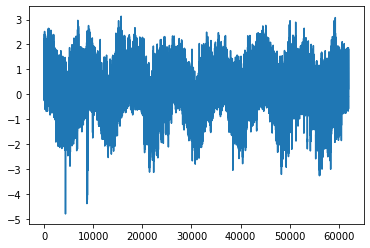

In [11]:
plt.plot(historico["Temperatura"])

In [12]:
base = historico.values
base

array([[2.014e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.014e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.014e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [2.021e+03, 1.000e+00, 2.600e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.021e+03, 1.000e+00, 2.600e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.021e+03, 1.000e+00, 2.600e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [15]:
diasAnteriores = 30*24

In [16]:
carga = []
temp = []
vetorDiaSemana = []
previsores = []
valorReal = []
batch = []

for i in range(diasAnteriores,len(base)):
    carga = base[(i - diasAnteriores):i,5]
    temp = base[(i+1 - diasAnteriores):i+1,4]
    vetorDiaSemana = base[(i+1 - diasAnteriores):i+1,6:]

    batch = np.column_stack((carga,temp,vetorDiaSemana))

    previsores.append(batch)    
    valorReal.append(base[i, 5])

previsores, valorReal = np.array(previsores), np.array(valorReal)
print(previsores)
print(previsores.shape)
valorReal

[[[ 1.48581631e-01 -8.57905469e-01  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.18755796e-01 -9.67522502e-01  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-5.13525672e-02 -1.13566832e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 6.61181571e-01  1.76038014e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 5.58054956e-01  1.65001207e+00  0.00000000e+00 ...  1.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 4.51642444e-01  9.60696294e-01  0.00000000e+00 ...  1.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[ 1.18755796e-01 -9.67522502e-01  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-5.13525672e-02 -1.13566832e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-5.13525672e-02 -1.26287368e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 5.58054956e-01  1.6

array([ 0.14049327,  0.00096902, -0.29400343, ...,  0.4774241 ,
        0.3657036 ,  0.22365174])

In [17]:
def createModel():
    model = Sequential()

    model.add(LSTM(units = 100, return_sequences = True,input_shape = (previsores.shape[1],9)))
    model.add(Dropout(0.5))

    # model.add(LSTM(units = 50, return_sequences = True))
    # model.add(Dropout(0.3))

    model.add(LSTM(units = 30))
    model.add(Dropout(0.5))

    model.add(Dense(units = 1, activation= "linear"))

    model.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["mean_absolute_error"])

    return model

In [18]:
es = EarlyStopping(monitor = "loss", min_delta = 1e-10, patience = 10, verbose = 1)
rlr = ReduceLROnPlateau(monitor = "loss", factor = 0.2, patience = 5, verbose = 1)
mcp = ModelCheckpoint(filepath=f"pesos-{hoje}.h5", monitor = "loss", save_best_only = True, verbose=1)

In [19]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = createModel()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 720, 100)          44000     
_________________________________________________________________
dropout (Dropout)            (None, 720, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                15720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 59,751
Trainable params: 59,751
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(previsores, valorReal, epochs = 100, batch_size = 32, callbacks=[es,rlr,mcp])

Epoch 1/100
1915/1915 [==============================] - 80s 39ms/step - loss: 0.1860 - mean_absolute_error: 0.3018

Epoch 00001: loss improved from inf to 0.10841, saving model to pesos-2021-02-10.h5
Epoch 2/100
1915/1915 [==============================] - 74s 39ms/step - loss: 0.0699 - mean_absolute_error: 0.1894

Epoch 00002: loss improved from 0.10841 to 0.06736, saving model to pesos-2021-02-10.h5
Epoch 3/100
1915/1915 [==============================] - 74s 39ms/step - loss: 0.0643 - mean_absolute_error: 0.1777

Epoch 00003: loss improved from 0.06736 to 0.06273, saving model to pesos-2021-02-10.h5
Epoch 4/100
1915/1915 [==============================] - 74s 39ms/step - loss: 0.0608 - mean_absolute_error: 0.1732

Epoch 00004: loss improved from 0.06273 to 0.06105, saving model to pesos-2021-02-10.h5
Epoch 5/100
1915/1915 [==============================] - 74s 39ms/step - loss: 0.0598 - mean_absolute_error: 0.1698

Epoch 00005: loss improved from 0.06105 to 0.05907, saving model to

# Teste e Validação


In [ ]:
model = keras.models.load_model('/content/pesos-2021-02-10.h5') # carrega modelo pré-treinado (OPCIONAL)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 720, 100)          44000     
_________________________________________________________________
dropout (Dropout)            (None, 720, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                15720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 59,751
Trainable params: 59,751
Non-trainable params: 0
_________________________________________________________________


In [22]:
testeDIR = "/content/drive/MyDrive/TG/TESTE" 

In [23]:
historicoCargaTeste = pd.read_csv(os.path.join(testeDIR,'SECO_2021-01-31_CARGAHIST.csv'),sep=";",decimal=",")
historicoTemperaturaTeste = pd.read_csv(os.path.join(testeDIR,'SECO_2021-01-31_TEMPHIST.csv'),sep=";",decimal=",")

In [59]:
historicoTeste = basePreprocessing(historicoCargaTeste, historicoTemperaturaTeste)

historicoTeste, _ , _ = baseNormalizer(historicoTeste,
                                        StandardScaler(),
                                        normalize_fit=True)

valorRealTeste = historicoTeste.iloc[:, 4].values
valorRealTeste

,Year,Month,Day,Hora,Carga,Temperatura,Dia_0,Dia_1,Dia_2,Dia_3,Dia_4,Dia_5,Dia_6
0,2014,1,1,1,-0.823276,0.147250,0,0,1,0,0,0,0
1,2014,1,1,2,-0.859091,0.117436,0,0,1,0,0,0,0
2,2014,1,1,3,-0.968578,-0.052604,0,0,1,0,0,0,0
3,2014,1,1,4,-1.136523,-0.052604,0,0,1,0,0,0,0
4,2014,1,1,5,-1.263577,-0.077364,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62082,2021,1,30,19,1.426467,1.293314,0,0,0,0,0,1,0
62083,2021,1,30,20,2.033632,1.007303,0,0,0,0,0,1,0
62084,2021,1,30,21,2.007901,0.652317,0,0,0,0,0,1,0
62085,2021,1,30,22,1.837635,0.408500,0,0,0,0,0,1,0


In [60]:
historicoTeste[["Carga"]] = normalizadorCarga.fit_transform(historicoTeste[["Carga"]])
historicoTeste[["Temperatura"]] = normalizadorTemp.fit_transform(historicoTeste[["Temperatura"]])
historicoTeste

,Year,Month,Day,Hora,Carga,Temperatura,Dia_0,Dia_1,Dia_2,Dia_3,Dia_4,Dia_5,Dia_6
0,2014,1,1,1,-0.823260,0.147255,0,0,1,0,0,0,0
1,2014,1,1,2,-0.859074,0.117441,0,0,1,0,0,0,0
2,2014,1,1,3,-0.968556,-0.052597,0,0,1,0,0,0,0
3,2014,1,1,4,-1.136496,-0.052597,0,0,1,0,0,0,0
4,2014,1,1,5,-1.263545,-0.077358,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62082,2021,1,30,19,1.426398,1.293311,0,0,0,0,0,1,0
62083,2021,1,30,20,2.033541,1.007302,0,0,0,0,0,1,0
62084,2021,1,30,21,2.007810,0.652318,0,0,0,0,0,1,0
62085,2021,1,30,22,1.837550,0.408503,0,0,0,0,0,1,0


In [61]:
entradas = historicoTeste.values
entradas.shape

(62081, 13)

In [89]:
X_teste = []
Y_teste = []
for i in range(len(entradas) - diasAnteriores,len(entradas)):
    cargaTeste = entradas[(i - diasAnteriores):i,4]
    cargaVerificada = entradas[i,4]
    tempTeste = entradas[(i+1 - diasAnteriores):i+1,5]
    vetorDiaSemana = entradas[(i+1 - diasAnteriores):i+1,6:]
    
    batchTeste = np.column_stack((cargaTeste,tempTeste,vetorDiaSemana))

    X_teste.append(batchTeste)
    Y_teste.append(cargaVerificada)
    
X_teste = np.array(X_teste)
Y_teste = np.array(Y_teste)
print(X_teste.shape)
print(Y_teste.shape)

(720, 720, 9)
(720,)


In [90]:
previsoes = model.predict(X_teste)

In [91]:
previsoes = normalizadorCarga.inverse_transform(previsoes)

In [ ]:
tf.keras.losses.MAPE(Y_teste, previsoes)

In [ ]:
previsoes

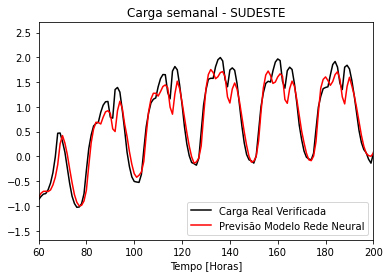

In [101]:
axes = plt.gca()
axes.set_xlim([60,200])
plt.plot(Y_teste[:], color = "black", label = "Carga Real Verificada")
plt.plot(previsoes[:], color = "red", label = "Previsão Modelo Rede Neural")
plt.title("Carga semanal - SUDESTE")
plt.xlabel("Tempo [Horas]")
plt.ylabel("")
plt.legend()
plt.show()